In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
# same optimization as last time
# max_steps = 200000
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


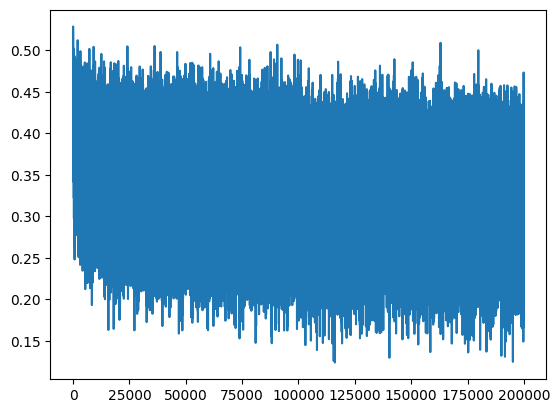

In [8]:
plt.plot(lossi)

In [9]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.10505747795105


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


In [12]:
# 4 dimensional example of the issue
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ -8.2900, -14.4979,  -6.3194,  -3.0780]),
 tensor([5.2179e-03, 1.0506e-05, 3.7439e-02, 9.5733e-01]),
 tensor(3.2850))

In [13]:
# 4 dimensional example of the issue
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-71.1939, 185.5531,  -2.1354,  72.6022]),
 tensor([0., 1., 0., 0.]),
 tensor(inf))

In [14]:
# Checking tanh activations

In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 2.0897


(array([448., 233., 219., 163., 132., 121., 113.,  96., 112.,  94., 111.,
         85.,  98., 128., 106.,  91.,  98.,  91., 105., 105.,  85., 106.,
         98.,  93.,  90., 106.,  73.,  92.,  92., 105.,  97., 100., 102.,
        109.,  90.,  96., 109.,  94., 100.,  80.,  90.,  99., 132., 109.,
        138., 154., 139., 196., 252., 425.]),
 array([-9.99996126e-01, -9.59998033e-01, -9.19999940e-01, -8.80001848e-01,
        -8.40003755e-01, -8.00005662e-01, -7.60007570e-01, -7.20009477e-01,
        -6.80011384e-01, -6.40013292e-01, -6.00015199e-01, -5.60017107e-01,
        -5.20019014e-01, -4.80020921e-01, -4.40022829e-01, -4.00024736e-01,
        -3.60026643e-01, -3.20028551e-01, -2.80030458e-01, -2.40032365e-01,
        -2.00034273e-01, -1.60036180e-01, -1.20038087e-01, -8.00399947e-02,
        -4.00419021e-02, -4.38094139e-05,  3.99542832e-02,  7.99523759e-02,
         1.19950469e-01,  1.59948561e-01,  1.99946654e-01,  2.39944746e-01,
         2.79942839e-01,  3.19940932e-01,  3.59939

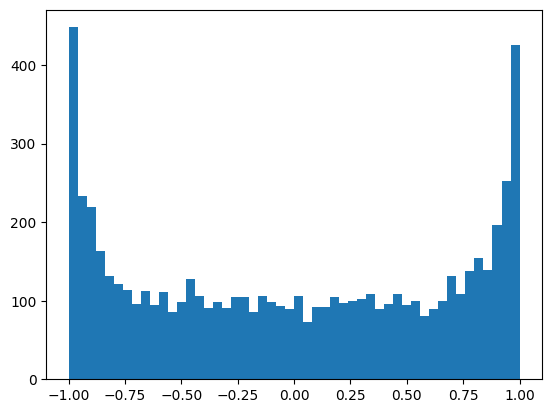

In [16]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   3.,   1.,   0.,   2.,   5.,   4.,   5.,   8.,
         11.,   7.,  23.,  27.,  42.,  58.,  63.,  81., 107., 150., 201.,
        229., 260., 303., 381., 489., 544., 522., 545., 442., 344., 328.,
        259., 227., 160., 169., 112.,  94.,  65.,  42.,  25.,  18.,  19.,
          6.,   4.,   5.,   4.,   3.,   2.]),
 array([-6.57423306, -6.34282518, -6.11141731, -5.88000944, -5.64860157,
        -5.4171937 , -5.18578583, -4.95437796, -4.72297009, -4.49156221,
        -4.26015434, -4.02874647, -3.7973386 , -3.56593073, -3.33452286,
        -3.10311499, -2.87170712, -2.64029924, -2.40889137, -2.1774835 ,
        -1.94607563, -1.71466776, -1.48325989, -1.25185202, -1.02044415,
        -0.78903627, -0.5576284 , -0.32622053, -0.09481266,  0.13659521,
         0.36800308,  0.59941095,  0.83081882,  1.0622267 ,  1.29363457,
         1.52504244,  1.75645031,  1.98785818,  2.21926605,  2.45067392,
         2.68208179,  2.91348967,  3.14489754,  3.37630541,  3.60771328,
 

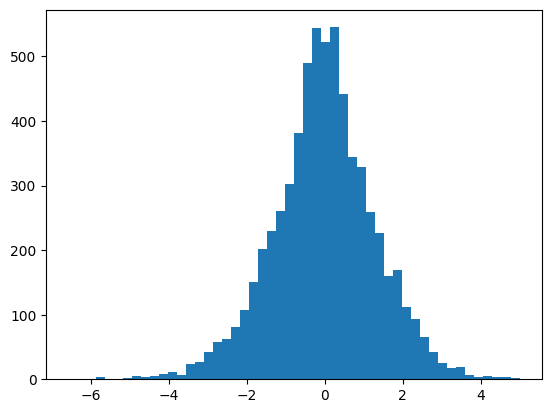

In [17]:
plt.hist(hpreact.view(-1).tolist(), 50)

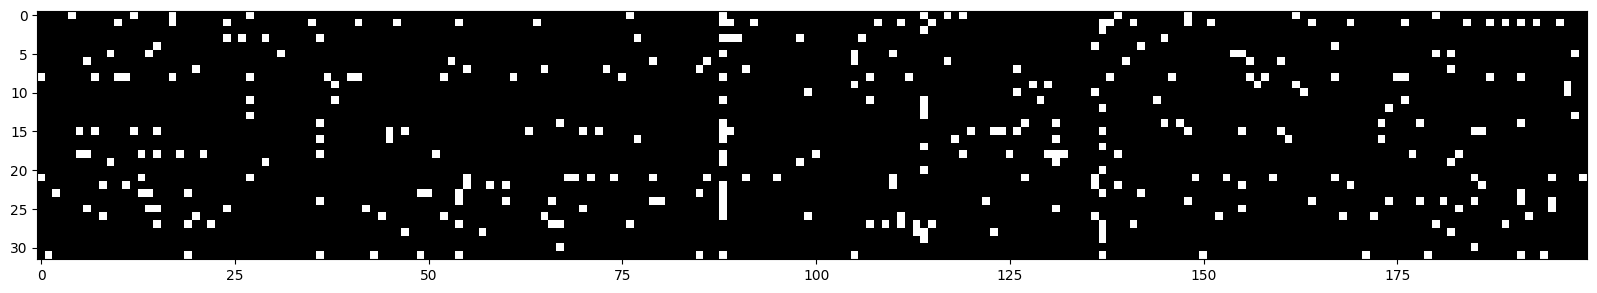

In [18]:
# Boolean tensor - white if it is true and black if it is false
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [19]:
# Remove bias, add batch normalization

In [20]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


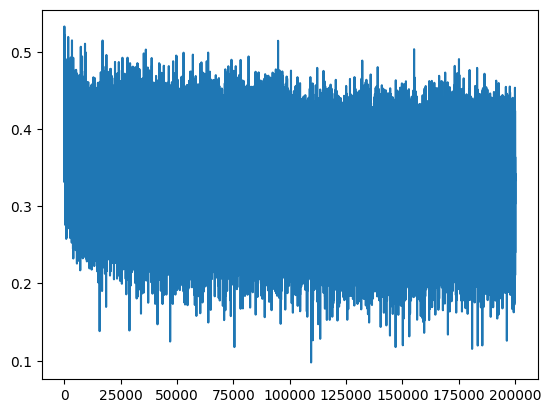

In [22]:
plt.plot(lossi)

In [23]:
# # calibrate the batch norm at the end of training

# with torch.no_grad():
#   # pass the training set through
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 # + b1
#   # measure the mean/std over the entire training set
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)

In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


loss log
original:
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491